# <center> <font style="color:rgb(100,109,254)"> Meanshift & Camshift</font> </center>

 In this Notebook, we will see two interesting object tracking algorithms namely Meanshift and CAMshift. It working of these algorithms is relatively simple and intuitive. It can easily be used for real time tracking, specially of tracking non-rigid objects. It is robust to occlusion, background clutter and variations in scale. 

First we'll see Meanshift and then see an improvement of this algorithm called CAMshift.

##   <font style="color:rgb(134,19,348)"> Meanshift   </font>
Meanshift is a pretty old and a really simple Object tracking algorithm.

The intuition behind the meanshift is simple. Consider you have a set of points. (It can be a pixel distribution like histogram back projection). You are given a small window (may be a circle) and you have to move that window to the area of maximum pixel density (or maximum number of points). It is illustrated in the simple image given below:

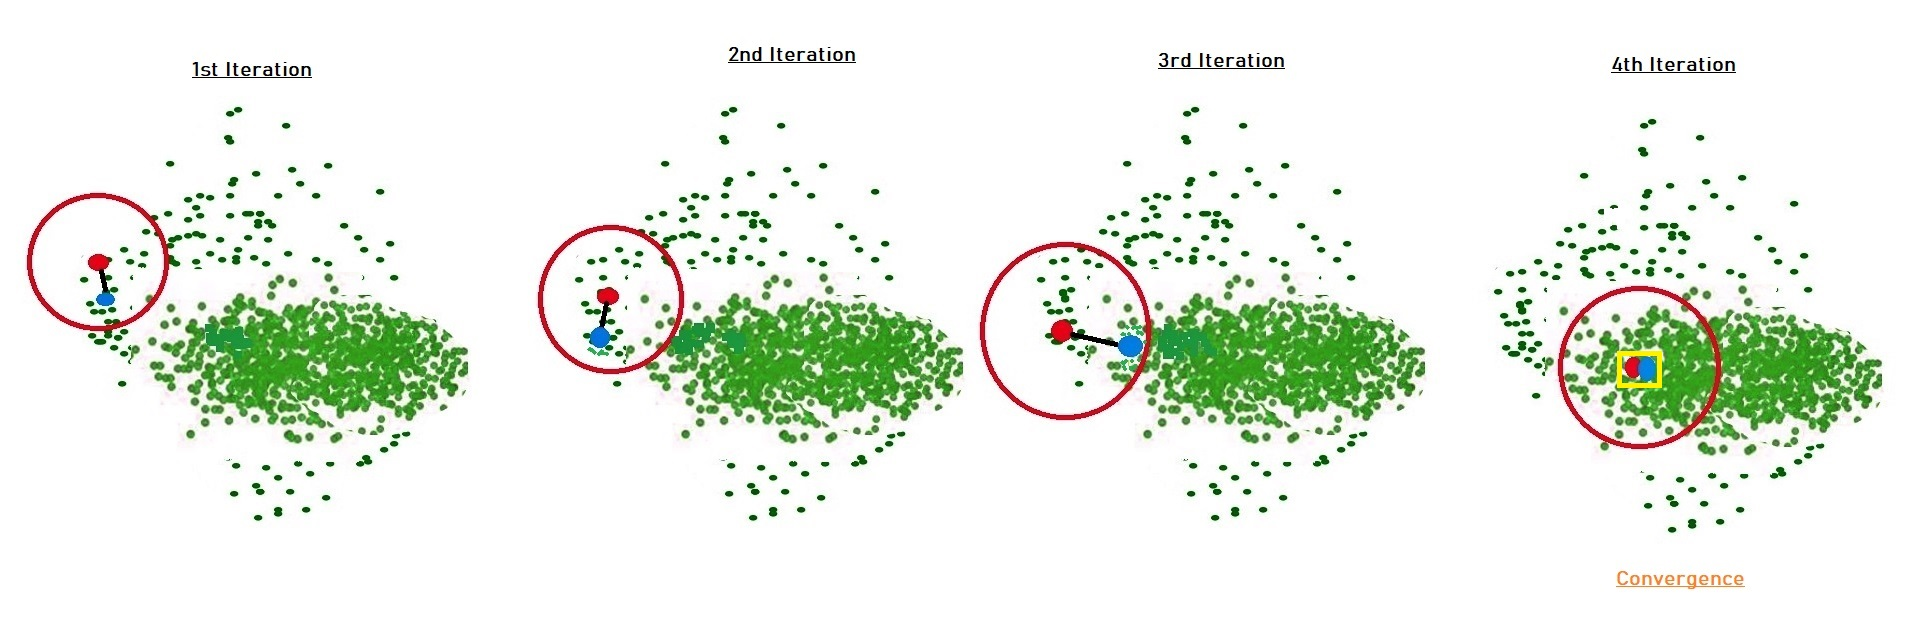
The initial window is shown in red circle. This is our tracking window. Its original center is marked in a red circle. But if you find the centroid of the points inside that window, you will get a different point(marked with a blue circle). which is the real centroid of the window. Surely they don't match. So now you move your window such that the circle of the new window matches with the previous centroid. Again find the new centroid. Most probably, it won't match. So move it again, and continue the iterations such that the center of window and its centroid falls on the same location (or within a small desired error). So finally what you obtain is a window with maximum pixel distribution. It is marked with a yellow rectangle. As you can see in the image, it has maximum number of points. The whole process is demonstrated on in the image below:
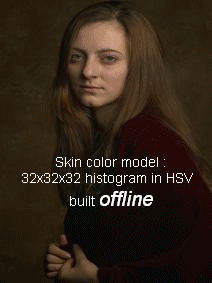

So we normally pass the histogram back projected image and initial target location. When the object moves, obviously the movement is reflected in the histogram back projected image. As a result, the meanshift algorithm moves our window to the new location with maximum density.

In [7]:
import cv2 
import numpy as np

## <font style="color:rgb(134,19,348)">  Meanshift in OpenCV  </font>
To use meanshift in OpenCV, first we need the roi of the target object then find its histogram so that we can backproject the target on each frame for calculation of meanshift. For histogram, only Hue is considered here. For better performance low light values are discarded using **cv2.inRange()** function.

So to perform Meanshift Tracking here are the steps

1. Get the histogram of the target object.
2. Get the probability map from histogram back projection
3. Pass in this map to the meanshift function and track the object.

[```retval, window = cv2.meanShift(probImage, window, criteria)```](https://docs.opencv.org/4.2.0/dc/d6b/group__video__track.html#ga432a563c94eaf179533ff1e83dbb65ea)

- **`probImage:`**	Back projection of the object histogram. See calcBackProject for details.
- **`window:`**	Initial search window.
- **`criteria:`**	Stop criteria for the iterative search algorithm. returns : Number of iterations meanshift took to converge. The function implements the iterative object search algorithm. It takes the input back projection of an object and the initial position. The mass center in window of the back projection image is computed and the search window center shifts to the mass center. The procedure is repeated until the specified number of iterations criteria.maxCount is done or until the window center shifts by less than criteria.epsilon. You can simply pass the output of calcBackProject to this function. But better results can be obtained if you pre-filter the back projection and remove the noise. For example, you can do this by retrieving connected components with findContours , throwing away contours with small area ( contourArea ), and rendering the remaining contours with drawContours.


In [9]:
cap = cv2.VideoCapture(1)

# Take first frame of the video
ret, frame = cap.read()

# Select the object you want to track in the video
r = cv2.selectROI(frame)
c,r,w,h = r
cv2.destroyAllWindows()

# Also set the track_window for meanshift
track_window = (c,r,w,h)

# Extract the ROI 
roi = frame[r:r+h, c:c+w]

# Convert to HSV.
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Eliminate lower valued values, Not required but improves results in cases.
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))  

# Calculate the histogram.
roi_hist = cv2.calcHist([hsv_roi],[0],None,[180],[0,180])  

# Normalize the histogram, Not required but may improve results.
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)   

# Setup the termination criteria, either 10 iteration or epison error of 1.
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    
    ret ,frame = cap.read()
    if not ret:
        break
    # Convert every new frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Calculate histogram backprojection using the stored histogram of roi 
    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
    
    # Apply Meanshift to get the new location.
    status, track_window = cv2.meanShift(dst, track_window, term_crit)
    
    # Extract the coordinates of object and draw a rectangle with it.
    x,y,w,h = track_window
    result = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
    cv2.putText(result,'Status: {}'.format(status),(10,30), cv2.FONT_HERSHEY_COMPLEX, 1, (200,255,155), 2, cv2.LINE_AA)

    
    cv2.imshow('Image', result)
    k = cv2.waitKey(60) & 0xff
    if k == 27:
        break
     
cv2.destroyAllWindows()
cap.release()

## <font style="color:rgb(134,19,348)">  Camshift In OpenCV  </font>

There is one major problem with Meanshift, it does not adapt to change in size, and any good tracker should be able to change in object size. So the solution to this problem came from "OpenCV Labs" and it is called **CAMshift (Continuously Adaptive Meanshift)** published by **Gary Bradsky** in his paper [**"Computer Vision Face Tracking for Use in a Perceptual User Interface"**. ](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf)

It applies meanshift first. Once meanshift converges, it updates the size of the window, so the width becomes: $$w = 2\sqrt{\frac{M_{oo}}{256}}$$
And length or height of window becomes: $h = 1.2w$

Where $ M_{oo}$ (zeroth moment) is the  sum of all pixels in the window of the back projected image.
$$ M_{oo}  = \sum_{x,y}BP(x,y) $$

This way CAMshift takes care of varying object size.

It also calculates the orientation of the best fitting ellipse to it. Again it applies the meanshift with new scaled search window and previous window location. The process continues until the required accuracy is met.

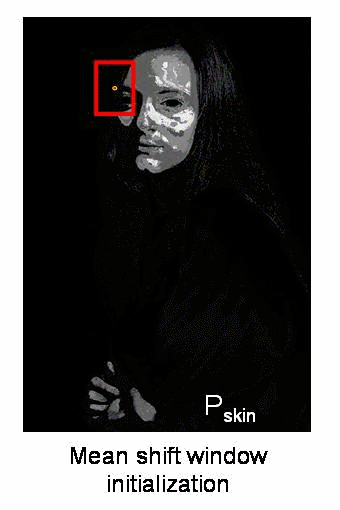

**So this way you have an algorithm that can vary and adjust size of bounding box and also account for orientation of object.**


[```rotated_window, window = cv2.CamShift(probImage, window, criteria)```](https://docs.opencv.org/4.2.0/dc/d6b/group__video__track.html#gaef2bd39c8356f423124f1fe7c44d54a1)


- **`probImage`**	Back projection of the object histogram. See calcBackProject for details.
- **`window`**	Initial search window.
- **`criteria`**	Stop criteria for the underlying meanShift. returns (in old interfaces) Number of iterations CAMSHIFT took to converge The function implements the CAMSHIFT object tracking algorithm [27] . First, it finds an object center using meanShift and then adjusts the window size and finds the optimal rotation. The function returns the rotated rectangle structure that includes the object position, size, and orientation. The next position of the search window can be obtained with cv2.boundingRect()

CAMshift is similar to meanshift, but returns a rotated rectangle (that is our result) and box parameters (used to be passed as search window in next iteration). See the code below:

In [10]:
cap = cv2.VideoCapture(1)

# Take first frame of the video
ret, frame = cap.read()

# Select the object you want to track in the video
r = cv2.selectROI(frame)
c,r,w,h = r
cv2.destroyAllWindows()

# Also set the track_window for camshift
track_window = (c,r,w,h)

# Extract the ROI 
roi = frame[r:r+h, c:c+w]

# Convert to HSV.
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Eliminate lower valued values, Not required but improves results in cases.
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))  

# Calculate the histogram.
roi_hist = cv2.calcHist([hsv_roi],[0],None,[180],[0,180])  

# Normalize the histogram, Not required but may improve results.
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)   

# Setup the termination criteria, either 10 iteration or epison error of 1.
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    
    ret ,frame = cap.read()
    if not ret:
        break
        
    # Convert every new frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Calculate histogram backprojection using the stored histogram of roi 
    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
    
    # Apply Camshift to get the new location.
    rotated_window, track_window = cv2.CamShift(dst, track_window, term_crit)
    
    # Take the rotated_window object (center,size and orientation) and return box points to draw with polylines.
    pts = cv2.boxPoints(rotated_window) 
    # Convert to int 64
    pts = np.int0(pts)
    # Draw a polygon
    result = cv2.polylines(frame,[pts],True, 255,2)
    
    cv2.imshow('Image', result)
    k = cv2.waitKey(60) & 0xff
    if k == 27:
        break
     
cv2.destroyAllWindows()
cap.release()